# Predicting Client Subscription to Term Deposits - Binary Classification Task

### Імпорт бібліотек

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

## Вибір моделей для навчання

У рамках розв’язання даної задачі бінарної класифікації я планую натренувати та порівняти чотири різні типи моделей машинного навчання. Це дозволить оцінити ефективність різних методів та вибрати найбільш відповідний для даного набору даних.

1. Logistic Regression
Це базова, інтерпретована та досить ефективна модель для задач класифікації. Потребує обробки викидів, масштабування числових ознак та кодування категоріальних змінних.

2. k-Nearest Neighbors (kNN)
Потребує масштабування ознак та кодування категоріальних змінних. Чутлива до шуму та викидів, особливо при малих значеннях k, що слід враховувати під час налаштування моделі.

3. Decision Tree
Не потребує масштабування ознак. Добре працює з категоріальними даними після кодування.
Має схильність до перенавчання, особливо при великій глибині дерева, тому важливо буде контролювати параметри моделі (max_depth, min_samples_split тощо).

4. XGBoost
Причина вибору: алгоритми бустінгу мають високу точність, добре працюють з незбалансованими даними та здатні враховувати складні взаємозв’язки між ознаками.
Потребує кодування категоріальних змінних, масштабування числових ознак зазвичай не є обов’язковим.
XGBoost підтримує налаштування параметрів для роботи з незбалансованими класами і має вбудовані механізми регуляризації для уникнення перенавчання.

## Вибір метрики

В даній задачі, коли клас 1 значно рідший (≈11.3%) важливо не пропустити клієнтів, які потенційно можуть погодитися на депозит. Тобто краще помилково звернутись до тих, хто відмовиться, ніж пропустити тих, хто міг би погодитись.

Основна метрика, яку я буду використовувати для оцінки і порівняння моделей - ROC AUC. Вона показує, наскільки модель впевнено відрізняє "yes" від "no", підходить для порівняння моделей незалежно від вибраного порогу, добре працює при дисбалансі класів.

Додатково буду дивитися на F1-score для класу 1, щоб розуміти, наскільки добре модель знаходить тих, хто погодиться.


In [ ]:
%load_ext autoreload
%autoreload all

Iмпортуємо функцію preprocess_data з модуля bank_preprocessing для препроцесингу наших даних для подальшої їх передачі в модель.

Даний модуль включає:
- очищення даних
- створення нових ознак
- поділ на навчальну та валідаційну вибірки
- кодування категоріальних змінних
- масштабування числових ознак
- окрему обробку нових (небачених) даних

Функції:

1. map_target_variable - перетворює цільову змінну 'y' з 'yes'/'no' на 1/0 — для роботи з ML-моделями.

2. handle_unknowns - обробка 'unknown'. Для колонок job, marital, education – замінює unknown на моду, в інших (default, housing, loan) – залишає як окрему категорію.

3. simplify_education - спрощує рівні освіти. Групує "basic.4y", "basic.6y", "basic.9y" в "basic". Застосовує порядкове кодування для всіх рівнів (ordinal encoding) на шкалі від 0 до 4.

4. clip_outliers - обрізає значення в колонці "campaign" на рівні 99-го перцентиля — для зменшення впливу викидів.

5. create_features - створює нові ознаки з існуючих.

6. split_data - ділить датасет на тренувальний і валідаційний з урахуванням балансу класів (stratify). Також видаляє колонку 'duration' як потенційно "data leakage".

7. encode_categorical_features - застосовує One-Hot Encoding до категоріальних змінних.

8. scale_numeric_features - опціонально масштабує числові ознаки за допомогою MinMaxScaler.

9. preprocess_data - об’єднує все в один повний пайплайн підготовки даних для моделі.

10. preprocess_new_data - обробляє нові дані:
Використовує вже навчені scaler та encoder. Опціонально створює нові ознаки.


Нові ознаки:

- contacted_before — чи з клієнтом контактували раніше.

- many_contacts — чи багато дзвінків (вище 75-го перцентиля).

- contact_ratio — співвідношення дзвінків у поточній кампанії до всіх дзвінків.

- previous_outcome_success — чи була попередня кампанія успішною.

взаємодії макроекономічних показників:
- euribor3m_to_emp.var.rate – показує, наскільки високими є процентні ставки відносно змін рівня зайнятості.

- cons.conf.idx_to_euribor3m – відображає довіру споживачів щодо майбутнього у контексті процентних ставок.

In [3]:
from bank_preprocessing import preprocess_data

In [4]:
# Завантажуємо дані
df = pd.read_csv("bank-additional-full.csv", sep=';')

# Переглядаємо перші кілька рядків
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
preprocessed_data = preprocess_data(df, 'y', create_features_flag = True)

In [6]:
X_train, y_train, X_val, y_val = preprocessed_data['X_train'], preprocessed_data['y_train'], preprocessed_data['X_val'], preprocessed_data['y_val']

In [7]:
X_train.columns

Index(['age', 'education', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'contacted_before', 'many_contacts', 'contact_ratio',
       'previous_outcome_success', 'euribor3m_to_emp.var.rate',
       'cons.conf.idx_to_euribor3m', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_wee

# Logistic Regression

In [ ]:
#Ініціалізація моделі
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000)

# Тренуємо модель
log_reg.fit(X_train, y_train) # Робимо передбачення

# Передбачення класів і ймовірностей
train_preds = log_reg.predict(X_train)
val_preds = log_reg.predict(X_val)

train_probs = log_reg.predict_proba(X_train)[:, 1]
val_probs = log_reg.predict_proba(X_val)[:, 1]

# Обчислюємо метрики
train_auroc = roc_auc_score(y_train, train_probs)
val_auroc = roc_auc_score(y_val, val_probs)

# Вивід результатів
print(f"AUROC на тренувальних даних: {train_auroc:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc:.4f}")

# Повні звіти
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_preds))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, val_preds))

AUROC на тренувальних даних: 0.7937
AUROC на валідаційних даних: 0.8067

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      9137
           1       0.37      0.64      0.47      1160

    accuracy                           0.84     10297
   macro avg       0.66      0.75      0.69     10297
weighted avg       0.88      0.84      0.86     10297

Confusion Matrix (Validation):
[[7874 1263]
 [ 413  747]]


Висновки:

Значення AUROC на валідаційних даних 0.8067 є досить хорошим результатом.

Валідаційний AUROC трохи вище тренувального — можливо, через регуляризацію або вдало підібрані гіперпараметри.

Як бачимо модель краще передбачає клас 0 ніж клас 1.

Але все ж непогано виявляє клієнтів, які підписують депозит — 747 правильних з 1160.

# K-Nearest Neighbors (kNN)

In [ ]:
# Ініціалізуємо kNN-класифікатор з параметрами за замовченням
knn = KNeighborsClassifier()

# Навчаємо модель
knn.fit(X_train, y_train)

# Передбачення класів і ймовірностей
train_preds = knn.predict(X_train)
val_preds = knn.predict(X_val)

train_probs = knn.predict_proba(X_train)[:, 1]
val_probs = knn.predict_proba(X_val)[:, 1]

# Обчислюємо метрики
train_auroc = roc_auc_score(y_train, train_probs)
val_auroc = roc_auc_score(y_val, val_probs)

# Вивід результатів
print(f"AUROC на тренувальних даних: {train_auroc:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc:.4f}")

# Повні звіти
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_preds))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, val_preds))


AUROC на тренувальних даних: 0.9235
AUROC на валідаційних даних: 0.7260

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      9137
           1       0.54      0.27      0.36      1160

    accuracy                           0.89     10297
   macro avg       0.73      0.62      0.65     10297
weighted avg       0.87      0.89      0.88     10297

Confusion Matrix (Validation):
[[8879  258]
 [ 851  309]]


AUROC на тренувальних даних становить 0.9235 - тобто модель дуже добре "вивчила" тренувальні дані, при цьому AUROC на валідаційних даних 0.7260 - модель значно гірше працює на нових (валідаційних) даних.

Модель добре вгадує клас 0, але має низький Recall для класу 1 — тільки 309 з 1160 передбачено правильно.

In [ ]:
f1_train1 = f1_score(y_train, train_preds, pos_label=1)
print(f"F1-score для класу 1 на тренувальних даних: {f1_train1:.4f}")

f1_val1 = f1_score(y_val, val_preds, pos_label=1)
print(f"F1-score для класу 1 на валідаційних даних: {f1_val1:.4f}")

F1-score для класу 1 на тренувальних даних: 0.4697
F1-score для класу 1 на валідаційних даних: 0.3578


Підберемо параметр n_neighbors для K-найближчих сусідів за допомогою GridSearchCV з 5-фолдною крос-валідацією

In [ ]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 20)}


# Використовуємо GridSearchCV з 5-фолдною крос-валідацією
knn_grid_search = GridSearchCV(knn, params_knn, cv=5, scoring='roc_auc')
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='roc_auc')

In [ ]:
# Отримуємо найкращий параметр n_neighbors
best_n_neighbors = knn_grid_search.best_params_['n_neighbors']
print(f"Найкраще значення n_neighbors: {best_n_neighbors}")

Найкраще значення n_neighbors: 19


In [ ]:
# Збережемо найкращу модель
knn_best = knn_grid_search.best_estimator_

In [ ]:
# Передбачення класів і ймовірностей
train_preds = knn_best.predict(X_train)
val_preds = knn_best.predict(X_val)

train_probs = knn_best.predict_proba(X_train)[:, 1]
val_probs = knn_best.predict_proba(X_val)[:, 1]

train_auroc_best = roc_auc_score(y_train, train_probs)
val_auroc_best = roc_auc_score(y_val, val_probs)

print(f"AUROC на тренувальних даних: {train_auroc_best:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc_best:.4f}")

# Повні звіти
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_preds))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, val_preds))

AUROC на тренувальних даних: 0.8601
AUROC на валідаційних даних: 0.7743

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9137
           1       0.67      0.21      0.33      1160

    accuracy                           0.90     10297
   macro avg       0.79      0.60      0.64     10297
weighted avg       0.88      0.90      0.88     10297

Confusion Matrix (Validation):
[[9017  120]
 [ 911  249]]


Висновки:
KNN добре класифікує клас 0, але слабко виявляє клас 1. Модель пропускає багато клієнтів, які насправді підписали депозит.

Модель непогана за AUROC, але недостатньо ефективна для виявлення потенційних клієнтів, що є головною метою.


# Decision Tree Classifier

In [ ]:
# Ініціалізуємо модель з фіксованим random_state
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Визначаємо сітку гіперпараметрів
param_grid = {
    'max_depth': range(1, 21, 2),       # Від 1 до 20 з кроком 2
    'max_leaf_nodes': range(2, 11, 1)   # Від 2 до 10 з кроком 1
}

# Ініціалізуємо GridSearchCV з 3-фолдною крос-валідацією
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Найкращі значення параметрів: {best_params}")

# Збережемо найкращу модель
dt_best = grid_search.best_estimator_



Найкращі значення параметрів: {'max_depth': 7, 'max_leaf_nodes': 10}


In [ ]:
# Передбачення класів і ймовірностей
train_preds = dt_best.predict(X_train)
val_preds = dt_best.predict(X_val)

train_probs = dt_best.predict_proba(X_train)[:, 1]
val_probs = dt_best.predict_proba(X_val)[:, 1]

# Оцінюємо AUROC для кращої моделі
train_auroc_dt = roc_auc_score(y_train, train_probs)
val_auroc_dt = roc_auc_score(y_val, val_probs)

print(f"AUROC на тренувальних даних: {train_auroc_dt:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc_dt:.4f}")

# Повні звіти
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_preds))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, val_preds))

AUROC на тренувальних даних: 0.7840
AUROC на валідаційних даних: 0.7952

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      9137
           1       0.38      0.64      0.48      1160

    accuracy                           0.84     10297
   macro avg       0.67      0.75      0.69     10297
weighted avg       0.89      0.84      0.86     10297

Confusion Matrix (Validation):
[[7945 1192]
 [ 421  739]]


Висновки:
AUROC на валідації становить 0.7952 — доволі високий, що свідчить про непогану здатність моделі розрізняти обидва класи.

F1 для класу 1 = 0.48 — вища, ніж у логістичної регресії (0.47) та значно краща, ніж у KNN (0.33). Це означає, що модель краще знаходить тих клієнтів, які підписали депозит.

Recall = 64% для класу 1 — хороша чутливість до цільової групи, модель вловлює значну частку потенційних клієнтів.



 # XGBoost модель

In [ ]:
# # Ініціалізуємо модель
xgb_model = XGBClassifier(random_state=42)


In [ ]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Оцінюємо точність моделі за AUROC
train_preds = xgb_model.predict(X_train)
val_preds = xgb_model.predict(X_val)

train_probs = xgb_model.predict_proba(X_train)[:, 1]
val_probs = xgb_model.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_preds)
val_auc = roc_auc_score(y_val, val_preds)

print(f'Train AUROC: {train_auc:.4f}')
print(f'Validation AUROC: {val_auc:.4f}')

# Повні звіти
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_preds))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, val_preds))

Train AUROC: 0.7119
Validation AUROC: 0.6241

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9137
           1       0.60      0.27      0.37      1160

    accuracy                           0.90     10297
   macro avg       0.75      0.62      0.66     10297
weighted avg       0.88      0.90      0.88     10297

Confusion Matrix (Validation):
[[8923  214]
 [ 845  315]]


Модель XGBoost, натренована зі стандартними параметрами, продемонструвала AUROC 0.7119 на тренувальних даних і 0.6241 на валідаційних. Це свідчить про помітне падіння здатності моделі розрізняти класи на нових даних, що вказує на перенавчання або обмежену загальну ефективність моделі без оптимізації гіперпараметрів.

### Randomized Search

In [ ]:
# Ініціалізуємо модель
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier()

# Простір гіперпараметрів
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 3]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Найкращі значення параметрів (RandomizedSearchCV):", random_search.best_params_)

# Збережемо найкращу модель
xgb_random_search = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Найкращі значення параметрів (RandomizedSearchCV): {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 3, 'colsample_bytree': 1.0}


In [ ]:
train_preds_random = xgb_random_search.predict(X_train)
val_preds_random = xgb_random_search.predict(X_val)

train_probs_random = xgb_random_search.predict_proba(X_train)[:, 1]
val_probs_random = xgb_random_search.predict_proba(X_val)[:, 1]

train_auroc_random = roc_auc_score(y_train, train_probs_random)
val_auroc_random = roc_auc_score(y_val, val_probs_random)

print(f"AUROC на тренувальних даних: {train_auroc_random:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc_random:.4f}")

# Повні звіти
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_preds_random))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, val_preds_random))

AUROC на тренувальних даних: 0.8255
AUROC на валідаційних даних: 0.8182

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9137
           1       0.68      0.24      0.35      1160

    accuracy                           0.90     10297
   macro avg       0.80      0.61      0.65     10297
weighted avg       0.88      0.90      0.88     10297

Confusion Matrix (Validation):
[[9008  129]
 [ 883  277]]


Модель XGBoost з тюнингом за допомогою Randomized Search показала AUROC 0.8255 на тренувальних та 0.8182 на валідаційних даних, що свідчить про її здатність досить добре відокремлювати класи. Близькі значення AUROC для обох вибірок свідчать про стабільність моделі без перенавчання.

Для класу 1 (клієнт погодився на депозит) модель демонструє precision 0.68, що означає, що  у більшості випадків, коли модель прогнозує "так", вона має рацію. Проте recall лише 0.24, тобто вона виявляє лише близько чверті всіх позитивних випадків.

F1 для класу 1 становить 0.35, що свідчить про слабкий баланс між точністю та повнотою для цього класу. У той же час F1 для класу 0 дорівнює 0.95, що підтверджує, що модель дуже добре справляється з прогнозуванням відмов.

### Тюнинг з Hyperopt

In [ ]:
!pip install hyperopt

In [14]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        scale_pos_weight =params['scale_pos_weight'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        )

    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = clf.predict_proba(X_val)[:, 1]
    auroc = roc_auc_score(y_val, y_pred)

    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.4),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 3),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3)
}


# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:42:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  1%|          | 1/100 [00:25<41:38, 25.24s/trial, best loss: -0.7603729908330283]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:42:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  2%|▏         | 2/100 [00:51<42:18, 25.91s/trial, best loss: -0.7738925758473504]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  3%|▎         | 3/100 [01:10<36:54, 22.83s/trial, best loss: -0.7738925758473504]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  4%|▍         | 4/100 [01:11<22:45, 14.23s/trial, best loss: -0.8093728417612359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 5/100 [01:20<19:28, 12.30s/trial, best loss: -0.8093728417612359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  6%|▌         | 6/100 [01:31<18:14, 11.65s/trial, best loss: -0.8093728417612359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  7%|▋         | 7/100 [01:40<16:40, 10.76s/trial, best loss: -0.8093728417612359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  8%|▊         | 8/100 [01:49<15:44, 10.27s/trial, best loss: -0.8093728417612359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  9%|▉         | 9/100 [01:52<12:14,  8.07s/trial, best loss: -0.8093728417612359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 10/100 [02:00<11:53,  7.92s/trial, best loss: -0.8093728417612359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 11%|█         | 11/100 [02:05<10:30,  7.08s/trial, best loss: -0.8093728417612359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▏        | 12/100 [02:11<10:07,  6.90s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 13%|█▎        | 13/100 [02:22<11:39,  8.04s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 14%|█▍        | 14/100 [02:31<12:03,  8.41s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 15/100 [02:34<09:40,  6.83s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 16%|█▌        | 16/100 [02:42<10:03,  7.19s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 17%|█▋        | 17/100 [02:44<07:29,  5.42s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 18%|█▊        | 18/100 [02:47<06:28,  4.73s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 19%|█▉        | 19/100 [02:52<06:32,  4.84s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 20/100 [03:00<07:53,  5.92s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 21%|██        | 21/100 [03:04<07:05,  5.39s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 22%|██▏       | 22/100 [03:06<05:40,  4.37s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 23%|██▎       | 23/100 [03:14<07:01,  5.47s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 24%|██▍       | 24/100 [03:17<05:51,  4.63s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 25/100 [03:22<05:41,  4.55s/trial, best loss: -0.8180795307446419]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 26%|██▌       | 26/100 [03:25<05:11,  4.21s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 27%|██▋       | 27/100 [03:31<05:56,  4.88s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 28%|██▊       | 28/100 [03:44<08:36,  7.18s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 29%|██▉       | 29/100 [03:49<07:49,  6.62s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 30/100 [04:08<11:52, 10.18s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 31%|███       | 31/100 [04:23<13:27, 11.70s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 32%|███▏      | 32/100 [04:36<13:44, 12.13s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 33%|███▎      | 33/100 [04:40<10:53,  9.76s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 34%|███▍      | 34/100 [04:43<08:24,  7.65s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 35/100 [04:45<06:25,  5.93s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 36%|███▌      | 36/100 [04:48<05:17,  4.96s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 37%|███▋      | 37/100 [04:54<05:39,  5.38s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 38/100 [05:00<05:47,  5.61s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 39%|███▉      | 39/100 [05:04<05:11,  5.11s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 40/100 [05:07<04:34,  4.58s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 41%|████      | 41/100 [05:12<04:29,  4.56s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 42%|████▏     | 42/100 [05:14<03:33,  3.68s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 43%|████▎     | 43/100 [05:17<03:27,  3.64s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 44%|████▍     | 44/100 [05:19<02:58,  3.19s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 45/100 [05:23<02:57,  3.23s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 46%|████▌     | 46/100 [05:35<05:20,  5.93s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 47%|████▋     | 47/100 [05:38<04:35,  5.20s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 48%|████▊     | 48/100 [05:44<04:38,  5.35s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 49%|████▉     | 49/100 [05:50<04:42,  5.54s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 50/100 [05:53<03:53,  4.67s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 51%|█████     | 51/100 [05:54<02:55,  3.58s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 52%|█████▏    | 52/100 [05:57<02:47,  3.48s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 53%|█████▎    | 53/100 [06:05<03:52,  4.95s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 54%|█████▍    | 54/100 [06:10<03:45,  4.91s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 55/100 [06:14<03:23,  4.52s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 56%|█████▌    | 56/100 [06:18<03:12,  4.38s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 57%|█████▋    | 57/100 [06:27<04:14,  5.92s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 58%|█████▊    | 58/100 [06:29<03:20,  4.77s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 59%|█████▉    | 59/100 [06:32<02:49,  4.15s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 60/100 [06:37<02:51,  4.28s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 61%|██████    | 61/100 [06:44<03:27,  5.31s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 62%|██████▏   | 62/100 [06:47<02:50,  4.49s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 63%|██████▎   | 63/100 [06:55<03:25,  5.56s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 64%|██████▍   | 64/100 [06:57<02:37,  4.37s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 65/100 [06:58<01:59,  3.41s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 66%|██████▌   | 66/100 [07:00<01:47,  3.17s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 67%|██████▋   | 67/100 [07:06<02:08,  3.91s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 68%|██████▊   | 68/100 [07:08<01:45,  3.31s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 69%|██████▉   | 69/100 [07:10<01:33,  3.01s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 70/100 [07:14<01:38,  3.28s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 71%|███████   | 71/100 [07:20<01:56,  4.03s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 72%|███████▏  | 72/100 [07:21<01:30,  3.23s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 73%|███████▎  | 73/100 [07:27<01:45,  3.90s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 74%|███████▍  | 74/100 [07:32<01:55,  4.44s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 75/100 [07:34<01:30,  3.62s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 76%|███████▌  | 76/100 [07:38<01:24,  3.53s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 77%|███████▋  | 77/100 [07:41<01:23,  3.65s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 78%|███████▊  | 78/100 [07:46<01:25,  3.87s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 79%|███████▉  | 79/100 [07:51<01:28,  4.24s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 80/100 [07:58<01:44,  5.22s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 81%|████████  | 81/100 [08:00<01:15,  3.99s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 82%|████████▏ | 82/100 [08:04<01:12,  4.03s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 83%|████████▎ | 83/100 [08:08<01:09,  4.10s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 84%|████████▍ | 84/100 [08:10<00:54,  3.40s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 85/100 [08:11<00:42,  2.81s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 86%|████████▌ | 86/100 [08:15<00:42,  3.04s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 87%|████████▋ | 87/100 [08:18<00:41,  3.17s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 88%|████████▊ | 88/100 [08:23<00:43,  3.64s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 89%|████████▉ | 89/100 [08:29<00:47,  4.30s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 90/100 [08:30<00:34,  3.47s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 91%|█████████ | 91/100 [08:37<00:38,  4.31s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 92%|█████████▏| 92/100 [08:42<00:37,  4.75s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 93%|█████████▎| 93/100 [08:49<00:37,  5.29s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 94%|█████████▍| 94/100 [08:51<00:26,  4.34s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 95/100 [09:00<00:29,  5.86s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 96%|█████████▌| 96/100 [09:02<00:18,  4.64s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 97%|█████████▋| 97/100 [09:07<00:14,  4.78s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 98%|█████████▊| 98/100 [09:09<00:07,  3.90s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 99%|█████████▉| 99/100 [09:15<00:04,  4.45s/trial, best loss: -0.8200502032282535]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 100/100 [09:21<00:00,  5.61s/trial, best loss: -0.8200502032282535]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.6657676431692532), 'gamma': np.float64(0.19331762293078075), 'learning_rate': np.float64(0.027435697918810266), 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 120, 'reg_alpha': np.float64(2.290481089194835), 'reg_lambda': np.float64(2.058931308831391), 'scale_pos_weight': np.float64(6.072552204614358), 'subsample': np.float64(0.7539647333572579)}


In [15]:
# Навчання фінальної моделі з найкращими гіперпараметрами
xgb_hyperopt_best = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    scale_pos_weight =best['scale_pos_weight'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    random_state=42

)

xgb_hyperopt_best.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:16:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:16:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6657676431692532, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.19331762293078075,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.027435697918810266,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [16]:
# Передбачення
xgb_train_preds = xgb_hyperopt_best.predict(X_train)
xgb_val_preds = xgb_hyperopt_best.predict(X_val)

xgb_train_probs = xgb_hyperopt_best.predict_proba(X_train)[:, 1]
xgb_val_probs = xgb_hyperopt_best.predict_proba(X_val)[:, 1]

# Оцінюємо AUROC для кращої моделі
final_train_auc = roc_auc_score(y_train, xgb_train_probs)
final_val_auc = roc_auc_score(y_val, xgb_val_probs)

print(f'Final Train AUROC: {final_train_auc:.4f}')
print(f'Final Validation AUROC: {final_val_auc:.4f}')

# Повні звіти
print("\nClassification Report (Validation):")
print(classification_report(y_val, xgb_val_preds))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, xgb_val_preds))

Final Train AUROC: 0.8333
Final Validation AUROC: 0.8188

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      9137
           1       0.44      0.63      0.52      1160

    accuracy                           0.87     10297
   macro avg       0.69      0.76      0.72     10297
weighted avg       0.89      0.87      0.88     10297

Confusion Matrix (Validation):
[[8190  947]
 [ 426  734]]


Висновки:
Модель XGBoost після тюнингу з hyperopt показує досить високу ефективність. Значення AUROC на тренувальних даних становить 0.83336, а на валідаційних — 0.8188, що говорить про хорошу здатність моделі відокремлювати клієнтів, які погодилися відкрити депозит, від тих, хто відмовився. Близькі значення AUROC для тренувального та валідаційного наборів даних свідчать про відсутність значного перенавчання.

Для класу 1 модель показує f1-метрику 0.52, що є значним покращенням у порівнянні з попередніми моделями (логістична регресія, дерево рішень, KNN). При цьому recall для цього класу становить 0.63, тобто модель правильно виявляє 63% клієнтів, які насправді відкрили депозит. Це особливо важливо в контексті банківського маркетингу, де головною метою є саме виявлення потенційних клієнтів.

Загалом, модель демонструє хороший баланс між точністю та повнотою. f1 для більшості класу (0) також висока — 0.93, що вказує на загальну стабільність класифікації.

Отже, цю модель доцільно використовувати для прогнозування результативності маркетингових кампаній, спрямованих на залучення клієнтів до відкриття депозитів.

In [17]:
# Збережемо нашу модель
import joblib
import os

# Створюємо директорію models
os.makedirs("models", exist_ok=True)

# Зберегти модель
joblib.dump(xgb_hyperopt_best, "models/xgb_model.joblib")

['models/xgb_model.joblib']

# Таблиця результатів

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score

# Моделі
models = {
    'Logistic Regression': log_reg,
    'KNN': knn_best,
    'Decision Tree': dt_best,
    'XGBoost': xgb_hyperopt_best
}

# Список для результатів
results = []

# Метрики для кожної моделі
for name, model in models.items():
    train_probs = model.predict_proba(X_train)[:, 1]
    val_probs = model.predict_proba(X_val)[:, 1]

    train_auroc = roc_auc_score(y_train, train_probs)
    val_auroc = roc_auc_score(y_val, val_probs)

    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    val_f1 = f1_score(y_val, val_preds, average='macro')

    val_f1_1 = f1_score(y_val, val_preds, pos_label=1)


    metrics = {
        'Model': name,
        'Parameters': model.get_params(),
        'Train AUROC': train_auroc,
        'Validation AUROC': val_auroc,
        'Validation F1 Macro': val_f1,
        'Validation F1 Class1': val_f1_1
        }

    results.append(metrics)

# Коментар до моделі
def evaluate_model(row):
    if row['Validation AUROC'] > 0.8 and row['Validation F1 Macro'] > 0.6 and row['Validation F1 Class1'] > 0.5:
        return 'Сильна модель з хорошим балансом між точністю та виявленням класу 1. Рекомендується для застосування.'
    elif row['Validation AUROC'] > 0.75 and row['Validation F1 Macro'] > 0.5 and row['Validation F1 Class1']> 0.45:
        return 'Модель показує задовільні результати, але може потребувати доопрацювання для покращення класифікації класу 1.'
    else:
        return 'Обмежена ефективність. Варто переглянути гіперпараметри або тип моделі.'




In [ ]:
# Створимо таблицю
pd.set_option('display.max_colwidth', None)

results_df = pd.DataFrame(results)
results_df['Comment'] = results_df.apply(evaluate_model, axis=1)

# Сортування за Validation AUROC
results_df = results_df.sort_values(by='Validation AUROC', ascending=False)

display(results_df)


,Model,Parameters,Train AUROC,Validation AUROC,Validation F1 Macro,Validation F1 Class1,Comment
3,XGBoost,"{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6657676431692532, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': True, 'eval_metric': None, 'feature_types': None, 'gamma': 0.19331762293078075, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.027435697918810266, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 120, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 2.290481089194835, 'reg_lambda': 2.058931308831391, 'sampling_method': None, 'scale_pos_weight': 6.072552204614358, 'subsample': 0.7539647333572579, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}",0.833303,0.818798,0.719690,0.516719,Сильна модель з хорошим балансом між точністю та виявленням класу 1. Рекомендується для застосування.
0,Logistic Regression,"{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",0.793677,0.806683,0.687552,0.471293,"Модель показує задовільні результати, але може потребувати доопрацювання для покращення класифікації класу 1."
2,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}",0.783977,0.795161,0.693003,0.478162,"Модель показує задовільні результати, але може потребувати доопрацювання для покращення класифікації класу 1."
1,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}",0.860149,0.774320,0.635812,0.325703,Обмежена ефективність. Варто переглянути гіперпараметри або тип моделі.


Таким чином, після налаштування за допомогою Hyperopt, модель XGBoost продемонструвала найкращі результати серед усіх протестованих моделей.

# Важливість ознак

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Витягуємо важливість
feature_importances = xgb_hyperopt_best.feature_importances_
features = X_train.columns

# Створюємо DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                       Feature  Importance
9                  nr.employed    0.444630
5                 emp.var.rate    0.124226
7                cons.conf.idx    0.040970
8                    euribor3m    0.027020
10            contacted_before    0.025469
46                   month_mar    0.022464
47                   month_may    0.020098
49                   month_oct    0.019743
13    previous_outcome_success    0.018361
6               cons.price.idx    0.016145
14   euribor3m_to_emp.var.rate    0.015974
3                        pdays    0.014894
40           contact_telephone    0.014081
15  cons.conf.idx_to_euribor3m    0.012090
31             default_unknown    0.011949
39            contact_cellular    0.010861
41                   month_apr    0.009190
30                  default_no    0.008766
21                 job_retired    0.006644
51             day_of_week_fri    0.006095
2                     campaign    0.006039
48                   month_nov    0.005624
55         

Результати:
Найвпливовіша ознака:
nr.employed (кількість зайнятих осіб) має найбільшу вагу — 0.4446, тобто 44.5% загального впливу серед усіх ознак.

Інші значущі ознаки:
emp.var.rate, cons.conf.idx, euribor3m, contacted_before — ознаки репрезентують економічні умови та історію контактів з клієнтом — важливі фактори і логічно, що мають сильний вплив на рішення клієнта щодо депозиту.

Ознаки з найменшим впливом:
default_yes, month_dec, month_jun, marital_status, деякі категорії роботи (наприклад, job_student, job_entrepreneur, job_admin.) мають близьку до нуля важливість.

Дуже низька важливість таких ознак як job, marital, housing, loan може викликати питання. У житті ці фактори все ж можуть мати вплив на фінансову поведінку людини. Проте їх низька важливість може пояснюватися тим, що економічні показники перекривають їх внесок або модель виявила слабкий статистичний зв’язок.

<ipython-input-34-e39b193a53ce>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='viridis')


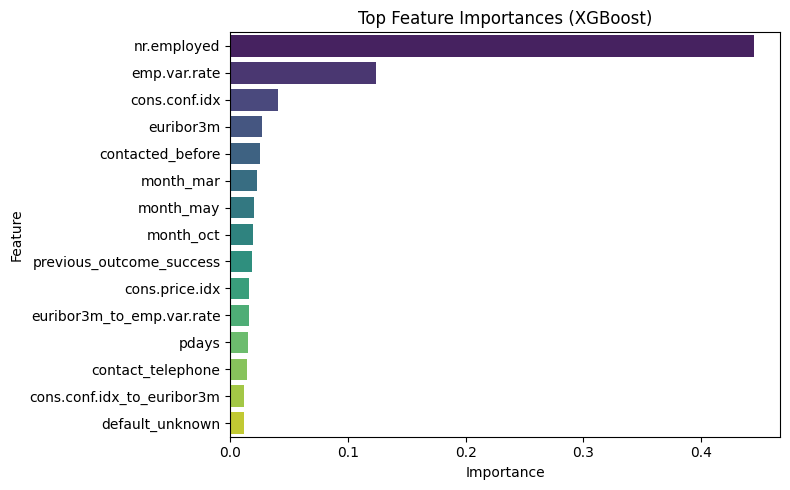

In [ ]:
# Виведемо топ-15
top_n = 15
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='viridis')
plt.title('Top Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [ ]:
y_train.value_counts()

,count
y,
0,27411
1,3480


# Аналіз впливу ознак на передбачення з допомогою бібліотеки SHAP

In [ ]:
! pip install shap

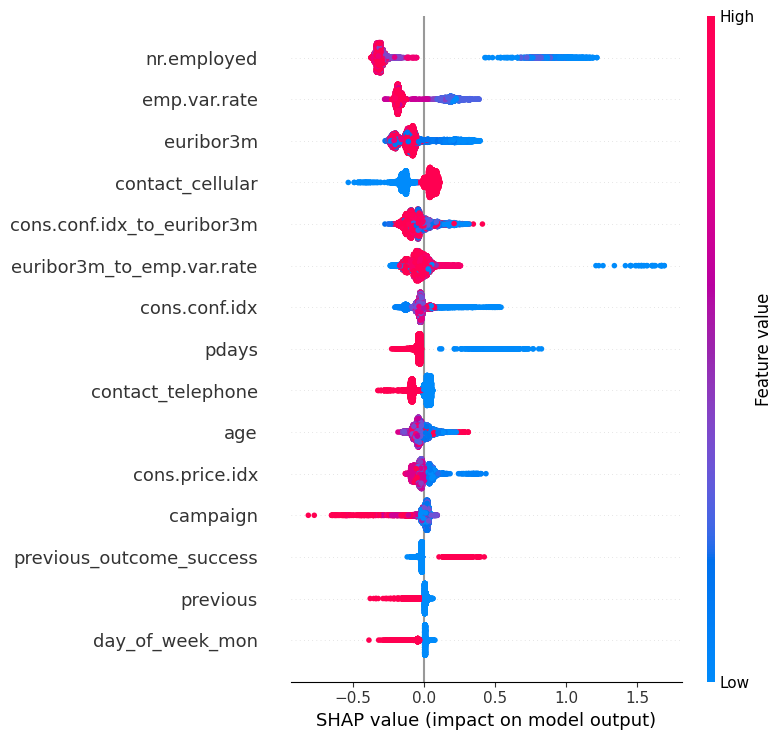

In [ ]:
import shap

# SHAP аналіз
explainer = shap.TreeExplainer(xgb_hyperopt_best)
shap_values = explainer.shap_values(X_val)

# Візуалізація важливості ознак
shap.summary_plot(shap_values, X_val, max_display=15)

SHAP-графік підтверджує адекватність роботи моделі:

Важливі економічні індикатори займають топові позиції.

Ознаки, що відображають історію взаємодії з клієнтом (наприклад, contacted_before, previous_outcome_success, contact_cellular), також демонструють вагомий вплив, що є очікуваним з огляду на їхню важливість у формуванні довіри та зацікавленості.

Висновок: модель орієнтується на найбільш релевантні ознаки — як з точки зору економіки, так і з точки зору поведінки клієнта. Це свідчить про її інтерпретованість та обґрунтованість.

# Аналіз помилок

In [ ]:
# Отримання ймовірностей та передбачень
probs = xgb_val_probs
preds = xgb_val_preds
true = y_val.values

# Класифікація помилок
results_df = pd.DataFrame({
    'true': true,
    'pred': preds,
    'pred_proba': probs
})

conditions = {
    'FP': (results_df['true'] == 0) & (results_df['pred'] == 1),
    'FN': (results_df['true'] == 1) & (results_df['pred'] == 0),
    }

for name, cond in conditions.items():
    results_df.loc[cond, 'error_type'] = name

# Розподіл помилок
print(results_df['error_type'].value_counts())


error_type
FP    947
FN    426
Name: count, dtype: int64


Ми створили датафрейм результатів results_df, який містить:

true — справжній клас, pred — передбачений клас, pred_proba — ймовірність передбачення класу 1

Ми також позначили помилки моделі:

FP (False Positives): справжній клас 0, але передбачено 1

FN (False Negatives): справжній клас 1, але передбачено 0

Розподіл помилок у нас наступний:

Модель у 947 випадках помилково визнала об'єкти позитивними, хоча насправді вони належали до негативного класу. Це свідчить про те, що модель має схильність надмірно "довіряти" позитивним сигналам.

FN (426 помилок): У 426 випадках модель не змогла виявити справжні позитивні приклади — вона віднесла їх до негативного класу.

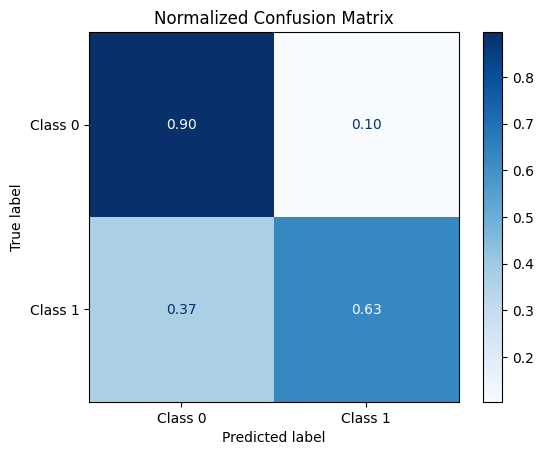

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Обчислення матриці помилок з нормалізацією
cm = confusion_matrix(results_df['true'], results_df['pred'], normalize='true')

# Створення об'єкта відображення
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# Візуалізація
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.grid(False)
plt.show()


Розглянемо у процентному співвідношенні:

Клас 0:
90% прикладів класу 0 були правильно класифіковані як клас 0 (True Negatives).

10% прикладів класу 0 були помилково класифіковані як клас 1 (False Positives).

Модель добре справляється з негативним класом, але іноді помилково “переоцінює” позитивність, створюючи хибні спрацьовування.

Клас 1:
63% прикладів класу 1 були правильно класифіковані (True Positives).

37% прикладів класу 1 були класифіковані як клас 0 (False Negatives).

Більше третини позитивних прикладів модель не виявляє, тобто пропускає важливі випадки.

In [ ]:
# Додамо до нашого датафрейму з помилками ознаки для контексту
features_df = X_val.copy()
features_df.reset_index(drop=True, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_full = pd.concat([features_df, results_df], axis=1)

# Відфльтруємо лише ті приклади, де була помилка
errors_df = results_full[results_full['true'] != results_full['pred']]

# Переглянемо перші 5 записів
display(errors_df.head())


,age,education,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,true,pred,pred_proba,error_type
0,0.296296,0.25,0.000000,1.0,0.0,0.333333,0.269680,0.192469,0.158694,0.512287,...,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0.316280,FN
2,0.481481,0.25,0.076923,1.0,0.0,0.000000,0.089634,1.000000,0.024484,0.203781,...,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0.719541,FP
10,0.345679,1.00,0.000000,1.0,0.0,0.104167,0.296960,0.418410,0.105418,0.425709,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.686586,FP
12,0.370370,1.00,0.000000,1.0,0.0,0.687500,0.389322,0.368201,0.840852,0.877883,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.710941,FP
14,0.185185,0.75,0.000000,1.0,0.0,0.937500,0.698753,0.602510,0.956926,0.859735,...,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0.133737,FN


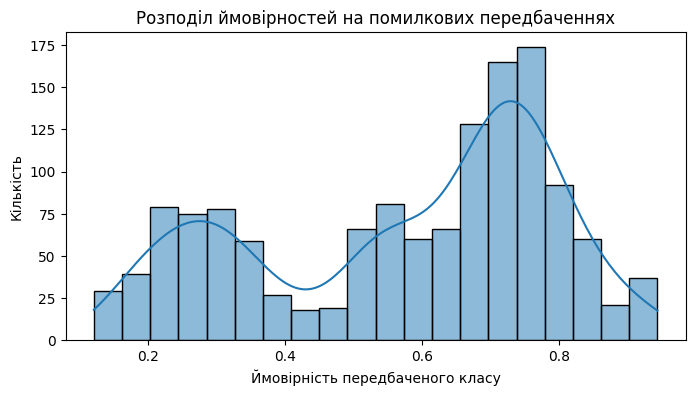

In [ ]:
# Аналіз розподілу ймовірностей на помилкових передбаченнях
plt.figure(figsize=(8, 4))
sns.histplot(data=errors_df, x="pred_proba", bins=20, kde=True)
plt.title("Розподіл ймовірностей на помилкових передбаченнях")
plt.xlabel("Ймовірність передбаченого класу")
plt.ylabel("Кількість")
plt.show()


Ми бачимо два виражені піки в розподілі:

Один із піків спостерігається в області 0.2–0.3 — це означає, що модель передбачала низьку ймовірність класу 1 (тобто скоріше вважала, що це клас 0), але насправді правильний клас був 1. Такі випадки вказують на false negatives.

Інший — в області 0.7–0.8 — модель була впевнена, що приклад належить до класу 1, але помилилася (можливі FP).

Можливо, причина частини помилок полягає у неоптимальному виборі порогу класифікації:
багато помилок припадає на діапазон ймовірностей 0.5–0.8, тож доцільно розглянути зміну порогу прийняття рішення — наприклад, встановити його не на стандартні 0.5, а на 0.6 або 0.7.

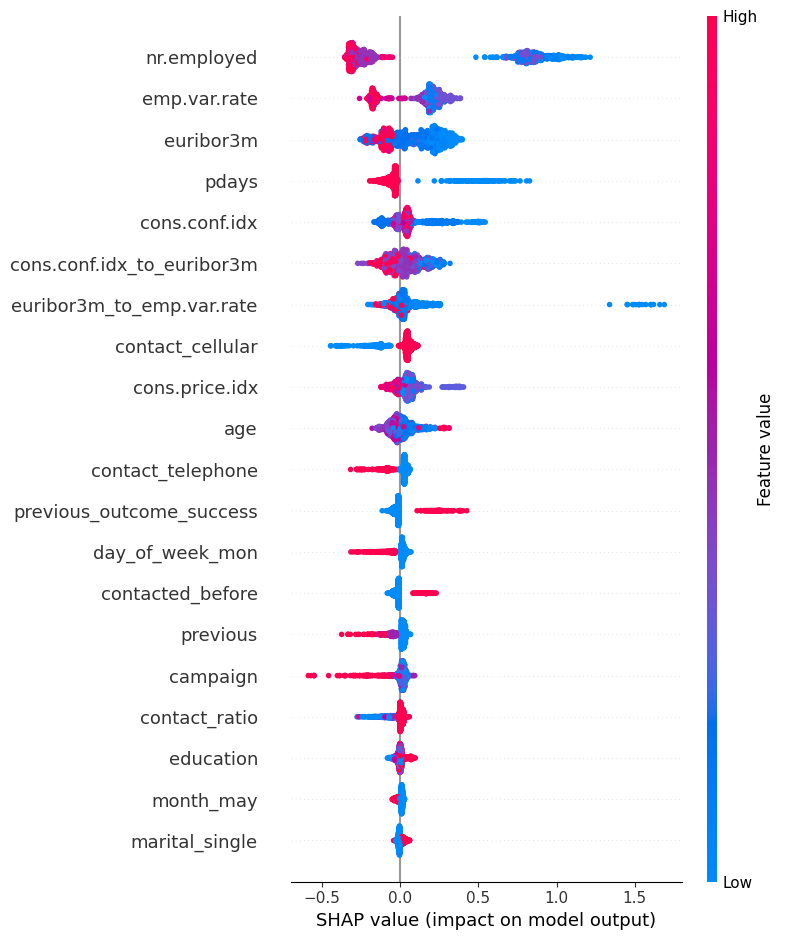

In [ ]:
import shap

# Створення explainer для XGBoost
explainer = shap.Explainer(xgb_hyperopt_best)

# Підготовка фіч
error_features = errors_df[X_val.columns]

# Обчислення SHAP значень
shap_values = explainer(error_features)

# Візуалізація важливості ознак
shap.summary_plot(shap_values, error_features, show=True)


SHAP-графік показує, що модель найчастіше помиляється через сильний вплив економічних показників, таких як nr.employed, emp.var.rate та euribor3m.

Також помилки часто виникають при обробці ознак, пов’язаних із каналом зв’язку та часом останнього контакту (pdays, contact_cellular). Це означає, що модель іноді неправильно оцінює значення цих факторів.

Ознаки, які ми створили cons.conf.idx_to_euribor3m або euribor3m_to_emp.var.rate також сильно впливають на прогноз, і це свідчити про неточну інтерпретацію складних взаємозв’язків між макроекономічними індикаторами.



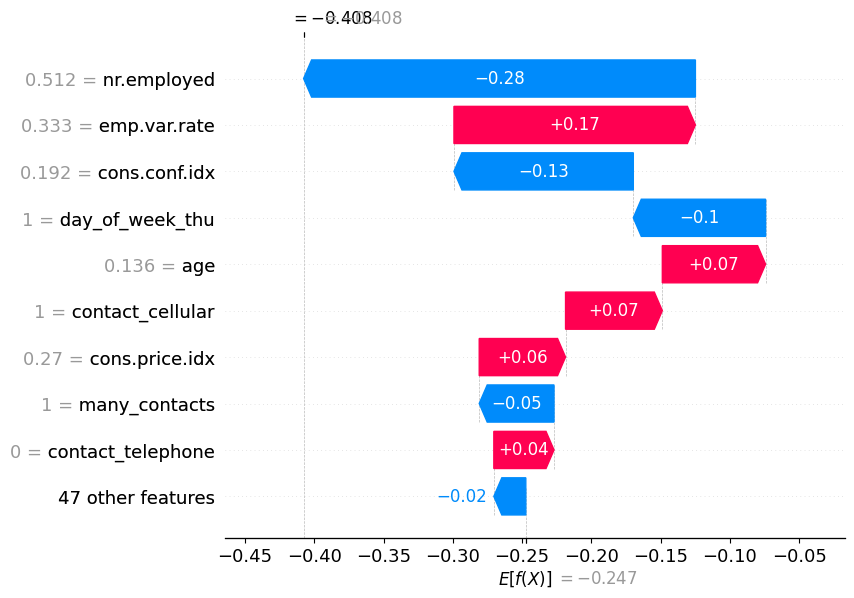

In [ ]:
# Вибиремо помилку, де модель впевнено віднесла приклад до класу 0 (proba < 0.15) і не вгадала
confident_error_FN = errors_df[(errors_df['pred_proba'] < 0.15)].iloc[0]

# Отримуємо індекс
idx = confident_error_FN.name

# SHAP waterfall plot
shap.plots.waterfall(shap_values[idx], max_display=10)

In [ ]:
print(confident_error_FN[-4:])

true                 1
pred                 0
pred_proba    0.148892
error_type          FN
Name: 338, dtype: object


Графік ілюструє чому модель з високою впевненістю (ймовірність < 0.15) передбачила відмову клієнта, але насправді він сказав "так".

Головний внесок у помилку дали такі ознаки:

nr.employed і cons.conf.idx сильно знизили ймовірність позитивної відповіді (відповідно на −0.28 і −0.13).

Це свідчить, що модель інтерпретувала економічне середовище як несприятливе для згоди клієнта.

emp.var.rate, contact_cellular, age додали позитивний вклад і підштовхнули модель до класу 1, але цього виявилось недостатньо.

Інші фічі, такі як day_of_week_thu, many_contacts дали внески, які разом посилили рішення моделі, що клієнт не погодиться.

Загальна оцінка моделі змістилася з базового рівня (−0.247) до ще більш негативного значення (−0.408), що спричинило впевнене передбачення відмови.

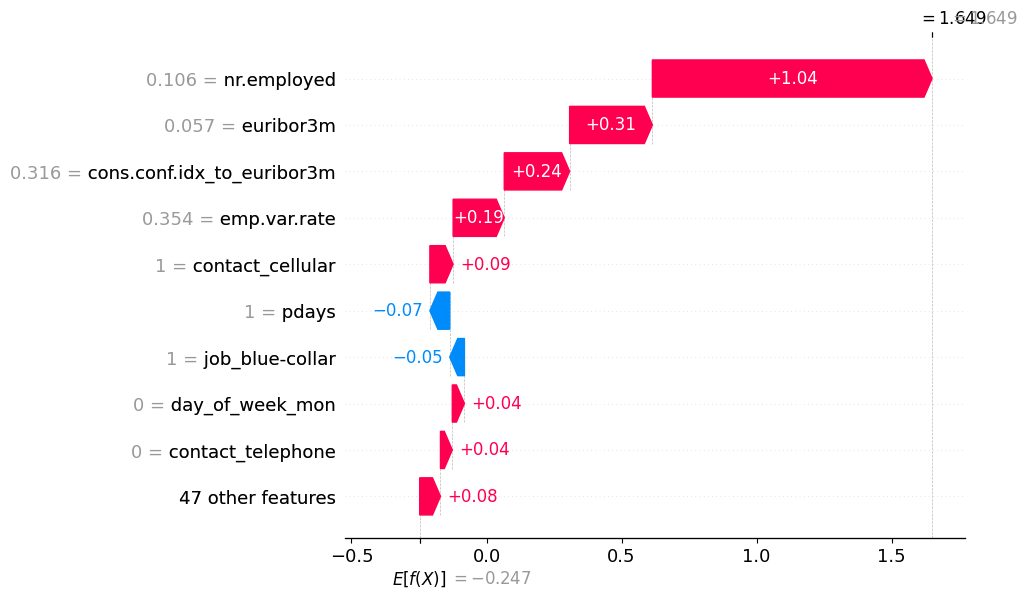

In [ ]:
# Вибиремо помилку, де модель впевнено віднесла приклад до класу 1 (наприклад, proba > 0.9) і не вгадала
confident_error_FP = errors_df[(errors_df['pred_proba'] > 0.9)].iloc[1]

# Отримуємо індекс
idx = confident_error_FP.name

# SHAP waterfall plot
shap.plots.waterfall(shap_values[idx], max_display=10)


In [ ]:
print(confident_error_FP[-4:])

true                 0
pred                 1
pred_proba    0.938927
error_type          FP
Name: 270, dtype: object


Цей графік показує чому модель вирішила, що клієнт точно погодиться, хоча насправді він відмовився. Найбільший вплив мали економічні ознаки — nr.employed, euribor3m і cons.conf.idx_to_euribor3m. Вони сильно змістили рішення моделі в бік позитивної відповіді. Додатково її переконали такі чинники, як висока змінність зайнятості (emp.var.rate) та мобільний тип зв’язку.


## Заключні висновки і подальші кроки

Заключні висновки:

Після проведеного аналізу результатів можна зробити наступні висновки:

XGBoost показав найкращі результати серед усіх протестованих моделей:

AUROC (Train: 0.833, Validation: 0.819) — свідчить про хорошу здатність відокремлювати клієнтів, які погодилися, від тих, хто відмовився.

F1 для класу 1 — 0.52, Recall — 0.63: модель досить ефективно виявляє потенційних клієнтів.

Високе F1 для класу 0 — 0.93 — вказує на загальну стабільність.

SHAP-аналіз підтвердив інтерпретованість моделі: економічні ознаки та фактори контакту є основними драйверами прогнозу.



Подальші кроки:
1. Перевірити оптимальність порогу класифікації
Стандартний поріг 0.5 може бути не оптимальним - можна протестувати пороги в діапазоні 0.6–0.65, щоб зменшити FP без значної втрати Recall для класу

2. Переглянути ознаки, створені в процесі feature engineering - ознаки euribor3m_to_emp.var.rate, cons.conf.idx_to_euribor3m хоч і мають відносно низьку важливість, часто впливають на неправильні рішення. Можливо, слід їх виключити і порівняти результати або замінити на більш інтерпретовані.

3. Аналіз false positives та false negatives - виявити спільні патерни серед FP та FN: наприклад, чи вони належать до певних вікових груп, каналів зв’язку, періодів часу. На основі цього створити сегментаційні фічі (наприклад, індикатор "молодий клієнт + мобільний зв’язок").

4. Протестувати інші стратегії балансування класів - спробувати SMOTE, ADASYN чи інші.
